## Usage Guide for the vision utils here

In [1]:
%load_ext autoreload
%autoreload 2


### Segmentation


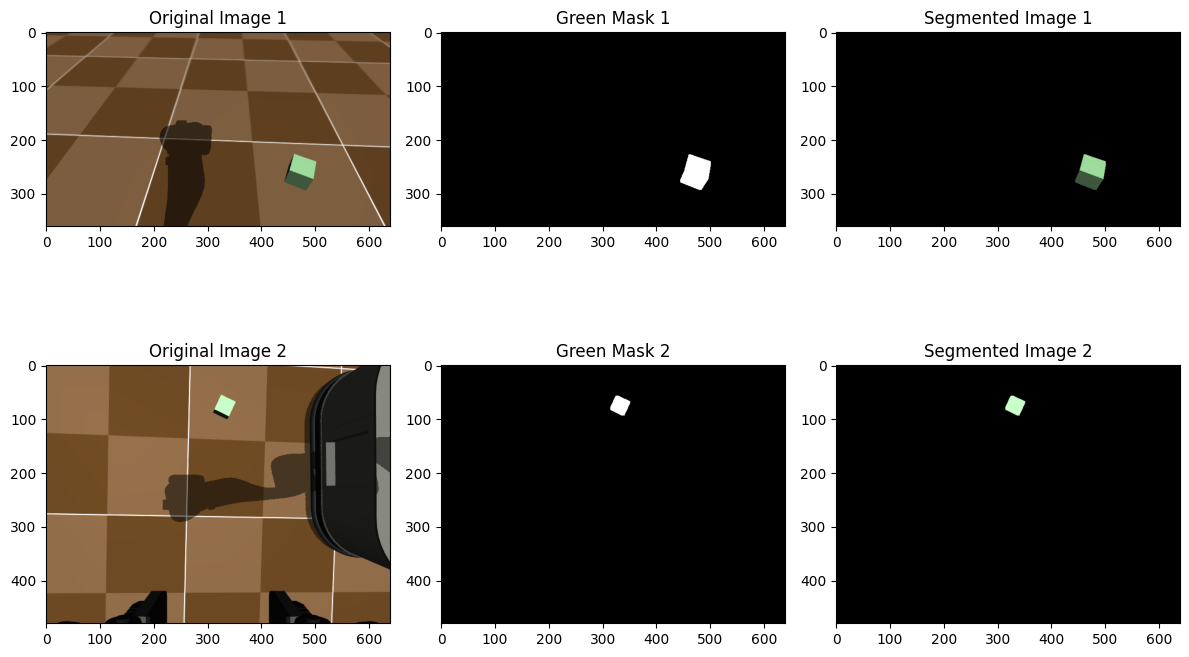

In [2]:
## HSV

from segmentation_utils import get_green_mask
import cv2
import numpy as np

import matplotlib.pyplot as plt

# Define paths for the images
image_path1 = "sample_images/base.png"
image_path2 = "sample_images/wrist.png"

# Load the images
img1 = cv2.imread(image_path1)
img2 = cv2.imread(image_path2)

# Convert from BGR to RGB for display
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# Get green masks for both images
mask1 = get_green_mask(img1_rgb)
mask2 = get_green_mask(img2_rgb)

# Apply masks to the original images
result1 = cv2.bitwise_and(img1_rgb, img1_rgb, mask=mask1)
result2 = cv2.bitwise_and(img2_rgb, img2_rgb, mask=mask2)

# Display the results
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.title("Original Image 1")
plt.imshow(img1)

plt.subplot(2, 3, 2)
plt.title("Green Mask 1")
plt.imshow(mask1, cmap='gray')

plt.subplot(2, 3, 3)
plt.title("Segmented Image 1")
plt.imshow(result1)

plt.subplot(2, 3, 4)
plt.title("Original Image 2")
plt.imshow(img2)

plt.subplot(2, 3, 5)
plt.title("Green Mask 2")
plt.imshow(mask2, cmap='gray')

plt.subplot(2, 3, 6)
plt.title("Segmented Image 2")
plt.imshow(result2)

plt.tight_layout()
plt.show()


### Grounding SAM

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision.ops import box_convert
import gc  # For garbage collection

# Import Grounding DINO
from groundingdino.util.inference import load_model, load_image, predict
import groundingdino.datasets.transforms as T

# Import Segment Anything
from segment_anything import sam_model_registry, SamPredictor

# Force CPU usage and disable CUDA
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # Hide all CUDA devices
device = "cpu"  # Explicitly use CPU
torch.set_num_threads(4)  # Adjust based on your CPU cores
print(f"Using device: {device}")
print(f"Using {torch.get_num_threads()} CPU threads")

# Define paths
current_dir = os.getcwd()
print(f"Current directory: {current_dir}")

image_path = os.path.join(current_dir, "sample_images/wrist.png")
print(f"Image path: {image_path}")

# Load the Grounding DINO model
GROUNDING_DINO_CONFIG_PATH = os.path.join(current_dir, "GroundingDINO/config/GroundingDINO_SwinT_OGC.py")
GROUNDING_DINO_CHECKPOINT_PATH = os.path.join(current_dir, "models/groundingdino_swint_ogc.pth")

print("Loading Grounding DINO model...")
grounding_dino_model = load_model(GROUNDING_DINO_CONFIG_PATH, GROUNDING_DINO_CHECKPOINT_PATH)
grounding_dino_model = grounding_dino_model.to(device)  # Explicitly move to CPU
print("Grounding DINO model loaded")

# Load the image for Grounding DINO
print("Loading image...")
image_source, image = load_image(image_path)
image = image.to(device)  # Ensure image is on CPU
print("Image loaded")

# Set the text prompt for Grounding DINO
TEXT_PROMPT = "green block"
BOX_THRESHOLD = 0.35
TEXT_THRESHOLD = 0.25

# Predict boxes with Grounding DINO
print(f"Running detection for prompt: '{TEXT_PROMPT}'")
with torch.no_grad():  # Disable gradient calculation to save memory
    # IMPORTANT: Explicitly specify device="cpu" in the predict function
    boxes, logits, phrases = predict(
        model=grounding_dino_model,
        image=image,
        caption=TEXT_PROMPT,
        box_threshold=BOX_THRESHOLD,
        text_threshold=TEXT_THRESHOLD,
        device=device  # Explicitly set device to CPU
    )

print(f"Found {len(boxes)} potential matches")

# Clear memory after Grounding DINO
del grounding_dino_model
gc.collect()

# Load the image for SAM
image_cv = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)

# Convert Grounding DINO boxes to SAM input format
H, W, _ = image_rgb.shape
boxes_xyxy = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy")
boxes_xyxy = boxes_xyxy * torch.Tensor([W, H, W, H])
boxes_xyxy = boxes_xyxy.cpu().numpy()

# Initialize SAM
SAM_CHECKPOINT_PATH = os.path.join(current_dir, "models/sam_vit_b_01ec64.pth")
MODEL_TYPE = "vit_b"  # Consider using "vit_b" if available for faster CPU processing

print("Loading SAM model...")
sam_model = sam_model_registry[MODEL_TYPE](checkpoint=SAM_CHECKPOINT_PATH)
sam_model.to(device)  # Explicitly move to CPU
predictor = SamPredictor(sam_model)
print("SAM model loaded")

# Set the image for the predictor
print("Setting image for SAM...")
predictor.set_image(image_rgb)
print("Image set for SAM")

# List to store masks
masks = []

# Process each detected box
for i, box in enumerate(boxes_xyxy):
    print(f"Processing detection {i+1}/{len(boxes_xyxy)}")
    
    # Convert box to the format SAM expects
    sam_box = box.astype(int)
    
    # Generate mask for the box
    with torch.no_grad():  # Disable gradient calculation to save memory
        masks_tensor, scores, logits = predictor.predict(
            box=sam_box,
            multimask_output=True
        )
    
    # Get the highest scoring mask
    best_mask_idx = np.argmax(scores)
    mask_data = {
        'segmentation': masks_tensor[best_mask_idx],
        'area': masks_tensor[best_mask_idx].sum(),
        'bbox': box.tolist(),
        'predicted_iou': scores[best_mask_idx].item(),
        'point_coords': None,
        'stability_score': None,
        'crop_box': None,
        'text': phrases[i]
    }
    masks.append(mask_data)
    print(f"  Mask generated with score: {scores[best_mask_idx]:.4f}")

# Clear memory after SAM
del sam_model, predictor
gc.collect()

# Visualize the masks
def show_anns(anns, ax):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax.imshow(image_rgb)
    ax.set_title("Green Block Detection with Grounding DINO + SAM")
    ax.axis('off')
    
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random(3)
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.5)), alpha=0.5)
        
        # Also show the bounding box from Grounding DINO
        if 'bbox' in ann:
            bbox = ann['bbox']
            rect = plt.Rectangle(
                (bbox[0], bbox[1]), 
                bbox[2] - bbox[0], 
                bbox[3] - bbox[1], 
                linewidth=2, 
                edgecolor='r', 
                facecolor='none'
            )
            ax.add_patch(rect)
            
            # Add text label
            if 'text' in ann:
                ax.text(
                    bbox[0], bbox[1] - 5, 
                    f"{ann['text']} ({ann['predicted_iou']:.2f})",
                    color='white', fontsize=10, 
                    bbox=dict(facecolor='red', alpha=0.5)
                )

# Display the results
print("Generating visualization...")
plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1)
show_anns(masks, ax)
plt.tight_layout()
plt.show()

print(f"Number of 'green block' instances detected: {len(masks)}")
for i, mask in enumerate(masks):
    print(f"  {i+1}. '{mask['text']}' with confidence: {mask['predicted_iou']:.4f}")

c:\Users\sidt3\anaconda3\envs\cs231a\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Starting direct download of NYU Depth V2 subset...


Extracting nyu_depth_data\nyu_depth_subset.zip...
Failed to download dataset: File is not a zip file

Creating visualization of samples...


NameError: name 'data_dir' is not defined

: 

In [ ]:
from grounded_sam import GroundingSAM

detector = GroundingSAM(
    grounding_dino_config_path="/home/sidt3/CS225A-Project/vision/GroundingDINO/config/GroundingDINO_SwinT_OGC.py",
    grounding_dino_checkpoint_path="models/groundingdino_swint_ogc.pth",
    sam_checkpoint_path="/home/sidt3/CS225A-Project/vision/models/sam_vit_b_01ec64.pth",
    device="cpu",  # or "cuda"
    optimization_level="medium",  # Options: "none", "light", "medium", "full"
    sam_model_type="vit_b"  # For faster CPU inference, use "vit_b"
)


Initializing GroundingSAM with device: cpu
Optimization level: medium
Loading Grounding DINO...
Error loading Grounding DINO: file "c:\home\sidt3\CS225A-Project\vision\GroundingDINO\config\GroundingDINO_SwinT_OGC.py" does not exist


FileNotFoundError: file "c:\home\sidt3\CS225A-Project\vision\GroundingDINO\config\GroundingDINO_SwinT_OGC.py" does not exist

Detection completed in 7.503s (Grounding DINO: 3.675s, SAM: 3.805s)
Found 1 objects matching 'golf ball'


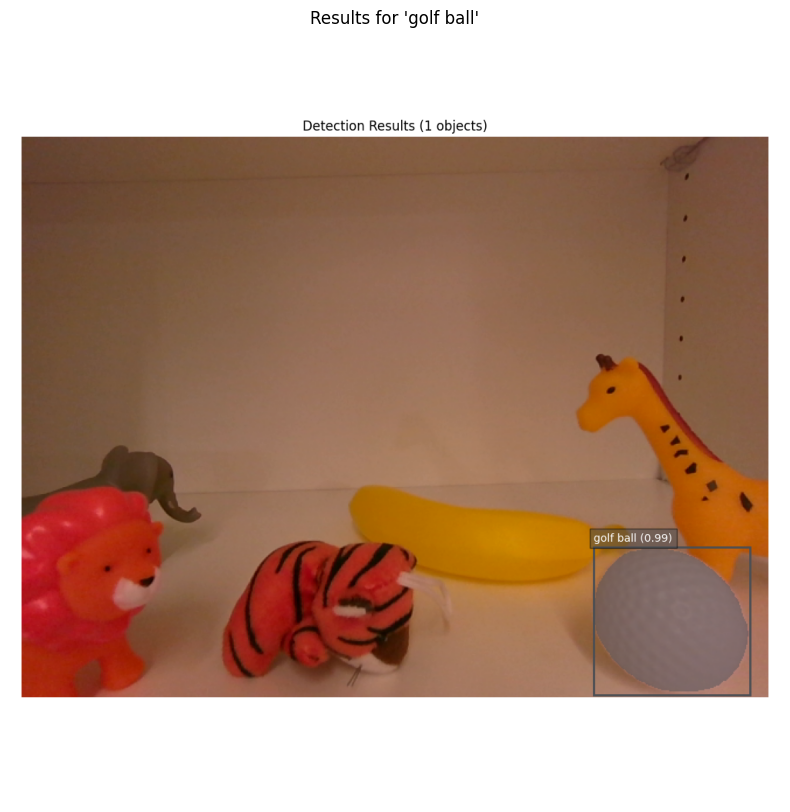

Found 1 objects
Average inference time: 7.962s


In [ ]:

# Run inference
results = detector.predict_mask(
    text_prompt="golf ball",
    image_path="../captured_d455_images/color_20250511_144456_124.png",
    visualize=True
)
print(f"Found {results.count} objects")
print(f"Average inference time: {detector.get_average_timings()['total']:.3f}s")


Detection completed in 8.286s (Grounding DINO: 4.477s, SAM: 3.788s)
Found 1 objects matching 'banana'


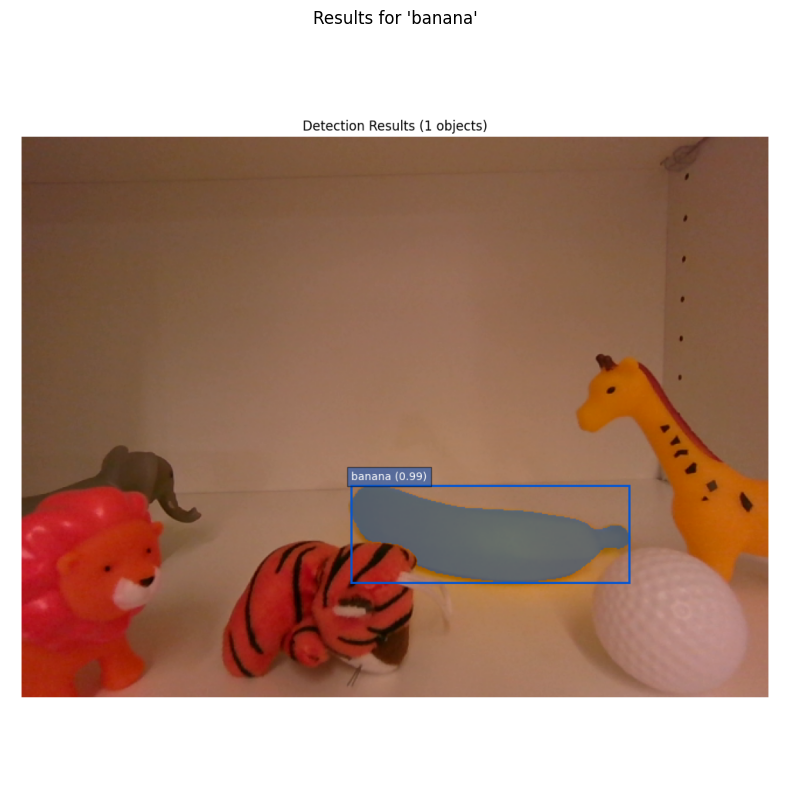

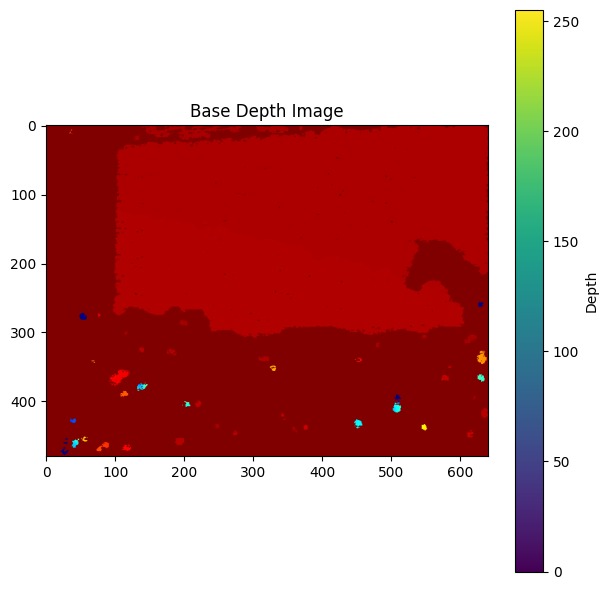

ValueError: too many values to unpack (expected 2)

In [ ]:

from depth_reconstruction import create_point_cloud

# The intrinsic matrix for base camera

K_base =  np.array([
    [386.0, 0.0, 640.0],
    [0.0, 386.0, 360.0],
    [0.0, 0.0, 1.0]
])

# The intrinsic matrix for wrist camera

K_wrist = np.array([[ 841.0,     0,    320 ],
    [   0,    630.73,   240 ],
    [   0,       0,      1  ]])

image_path1="../captured_d455_images/color_20250511_144456_124.png"

image_path1_depth = "../captured_d455_images/depth_colormap_20250511_144456_124.png"
# Load the images
img1 = cv2.imread(image_path1)

# Convert from BGR to RGB for display
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

mask1 = detector.predict_mask(
    text_prompt="banana",
    image_path=image_path1,
    visualize=True
).masks[0]





# Load the depth images
img1_depth =cv2.imread(image_path1_depth, cv2.IMREAD_UNCHANGED)
# Visualize the depth images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Base Depth Image")
plt.imshow(img1_depth, cmap='viridis')
plt.colorbar(label='Depth')


plt.tight_layout()
plt.show()

# We don't need to read img1 and img2 again since they are already defined
# Create point clouds using the RGB images, depth images, masks and camera intrinsics
pcd_base = create_point_cloud(img1_rgb, img1_depth, mask1, K_base)





### Point Cloud Extraction

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Detection completed in 8.897s (Grounding DINO: 4.134s, SAM: 4.745s)
Found 1 objects matching 'green cube'


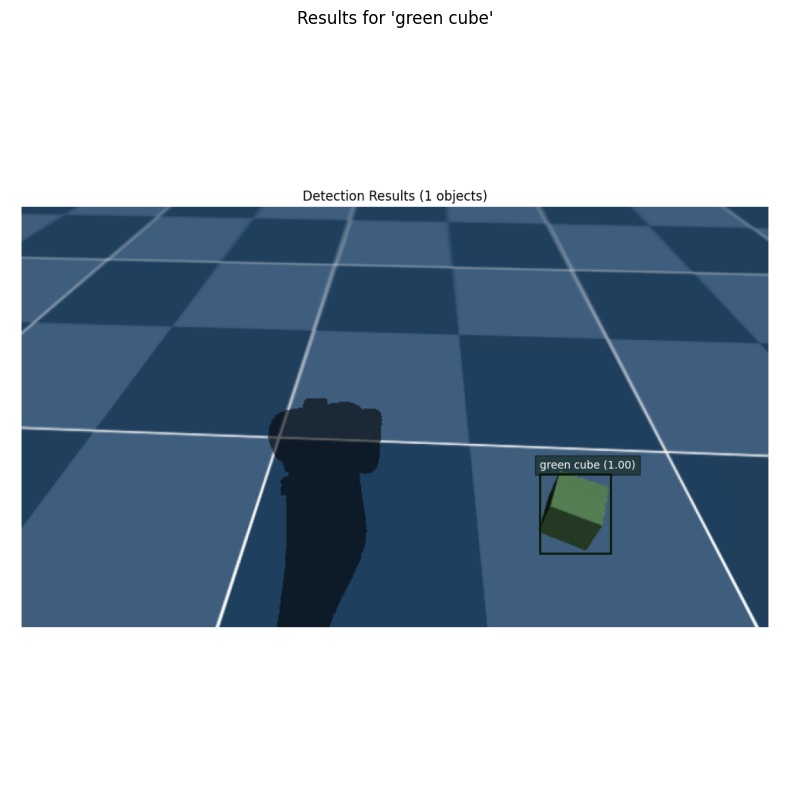

Detection completed in 8.407s (Grounding DINO: 4.215s, SAM: 4.176s)
Found 1 objects matching 'green cube'


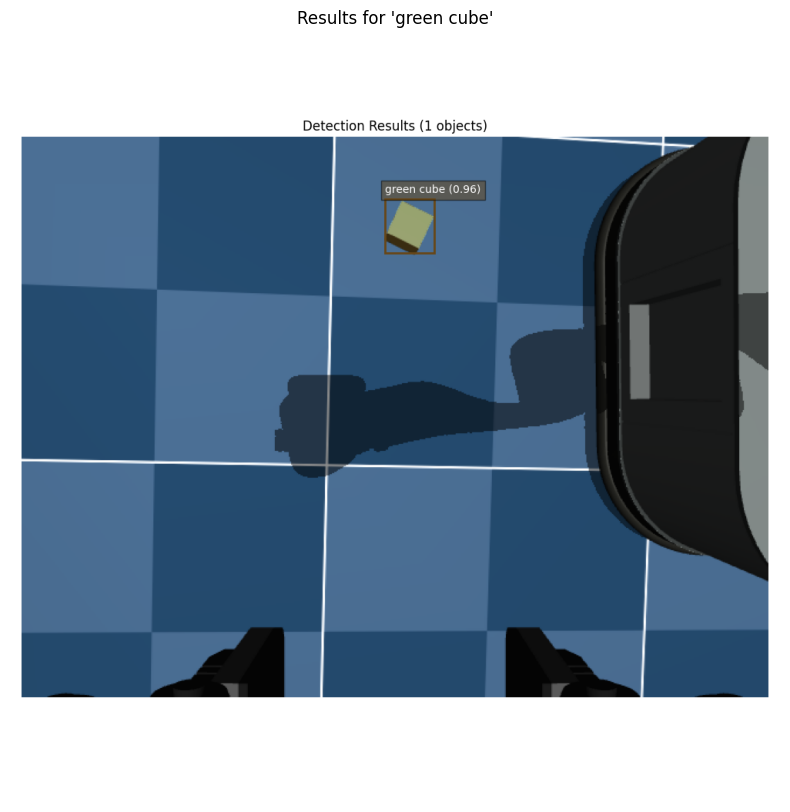

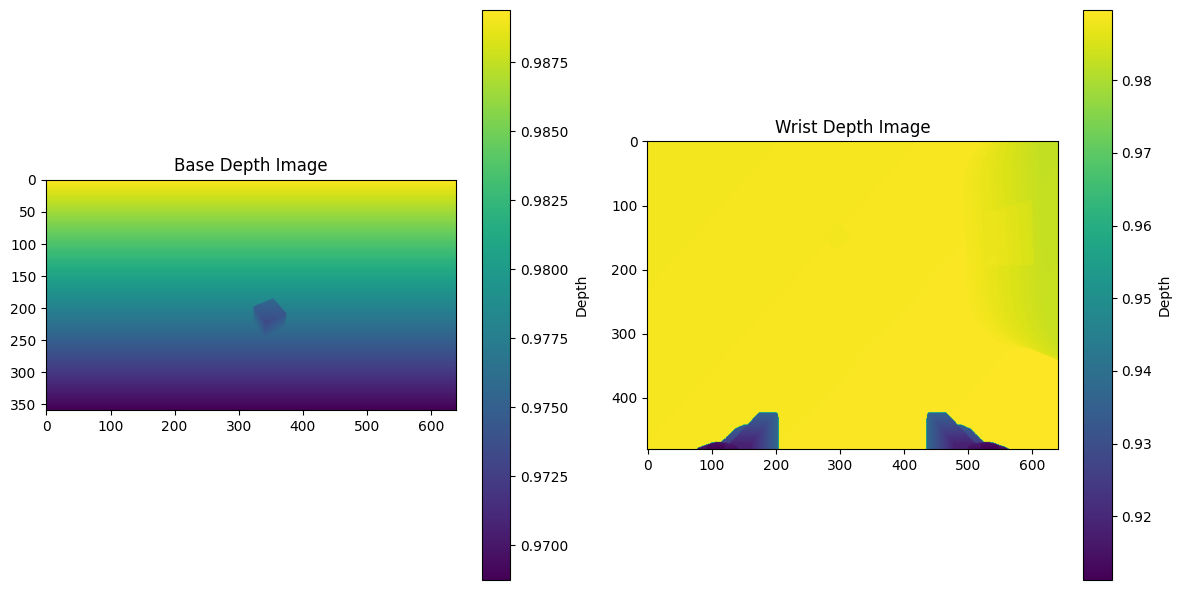

Created point cloud with 2688 points
Point cloud bounds: min=[0.18222345 0.12422913 0.97254014], max=[0.27020478 0.29751756 0.97633523]
Created point cloud with 1120 points
Point cloud bounds: min=[-0.00940504 -0.28999135  0.98868227], max=[ 0.03762139 -0.21946881  0.98875427]


In [ ]:
from depth_reconstruction import create_point_cloud

# The intrinsic matrix for base camera

K_base = np.array([[ 657.12,  0,    320 ],
    [    0,   369.38,  180 ],
    [    0,      0 ,     1 ]])

# The intrinsic matrix for wrist camera

K_wrist = np.array([[ 841.0,     0,    320 ],
    [   0,    630.73,   240 ],
    [   0,       0,      1  ]])

image_path1 = "sample_images/base.png"
image_path2 = "sample_images/wrist.png"

image_path1_depth = "sample_images/base_depth.png"
image_path2_depth = "sample_images/wrist_depth.png"
# Load the images
img1 = cv2.imread(image_path1)
img2 = cv2.imread(image_path2)

# Convert from BGR to RGB for display
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

mask1 = detector.predict_mask(
    text_prompt="green cube",
    image_path="sample_images/base.png",
    visualize=True
).masks[0]

mask2 = results = detector.predict_mask(
    text_prompt="green cube",
    image_path="sample_images/wrist.png",
    visualize=True
).masks[0]




# Load the depth images
img1_depth =np.load('sample_images/base_depth.npy').squeeze()
img2_depth = np.load('sample_images/wrist_depth.npy').squeeze()
# Visualize the depth images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Base Depth Image")
plt.imshow(img1_depth, cmap='viridis')
plt.colorbar(label='Depth')

plt.subplot(1, 2, 2)
plt.title("Wrist Depth Image")
plt.imshow(img2_depth, cmap='viridis')
plt.colorbar(label='Depth')

plt.tight_layout()
plt.show()

# We don't need to read img1 and img2 again since they are already defined
# Create point clouds using the RGB images, depth images, masks and camera intrinsics
pcd_base = create_point_cloud(img1_rgb, img1_depth, mask1, K_base)
pcd_wrist = create_point_cloud(img2_rgb, img2_depth, mask2, K_wrist)





In [ ]:
from grasp_detection import predict_grasp_from_numpy

grasp_location = predict_grasp_from_numpy(pcd_base)
grasp_location = predict_grasp_from_numpy(pcd_base)
print(grasp_location)

(0.22776817363506732, 0.21038255828216051, 0.9744512906874574)
